# Churn Factor Indicator

**Formula**: `Volume / (High - Low)`

Measures trading activity relative to price range. High churn indicates:
- Lots of trading within a narrow price range
- Strong support/resistance levels
- Accumulation or distribution phases
- Potential breakout preparation

**Interpretation:**
- **High Churn**: Heavy volume + tight range = strong interest at price level
- **Low Churn**: Large price swings + normal/low volume = trending market

In [1]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from indikator.churn_factor import churn_factor

np.random.seed(42)

2025-11-26 15:27:02.665 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'threshold' has constraints: {'ge': 0.0, 'le': 1.0}
2025-11-26 15:27:02.665 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'min_distance_pct' has constraints: {'ge': 0.0, 'le': 1.0}
2025-11-26 15:27:02.666 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'confirmation_bars' has constraints: {'ge': 0}
2025-11-26 15:27:02.666 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constraints: {'gt': 0.0}
2025-11-26 15:27:02.670 | DEBUG    | hipr.config:configurable:705 - Creating Config for 'zigzag_legs' with 4 hyperparameter(s): ['threshold', 'min_distance_pct', 'confirmation_bars', 'epsilon']
2025-11-26 15:27:02.674 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'fill_value' has constraints: {'gt': 0.0}
2025-11-26 15:27:02.675 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constra

## Scenario 1: Support/Resistance Detection
High churn factor reveals tight consolidation zones where price is being defended

/tmp/user/ipykernel_1465937/3765687457.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


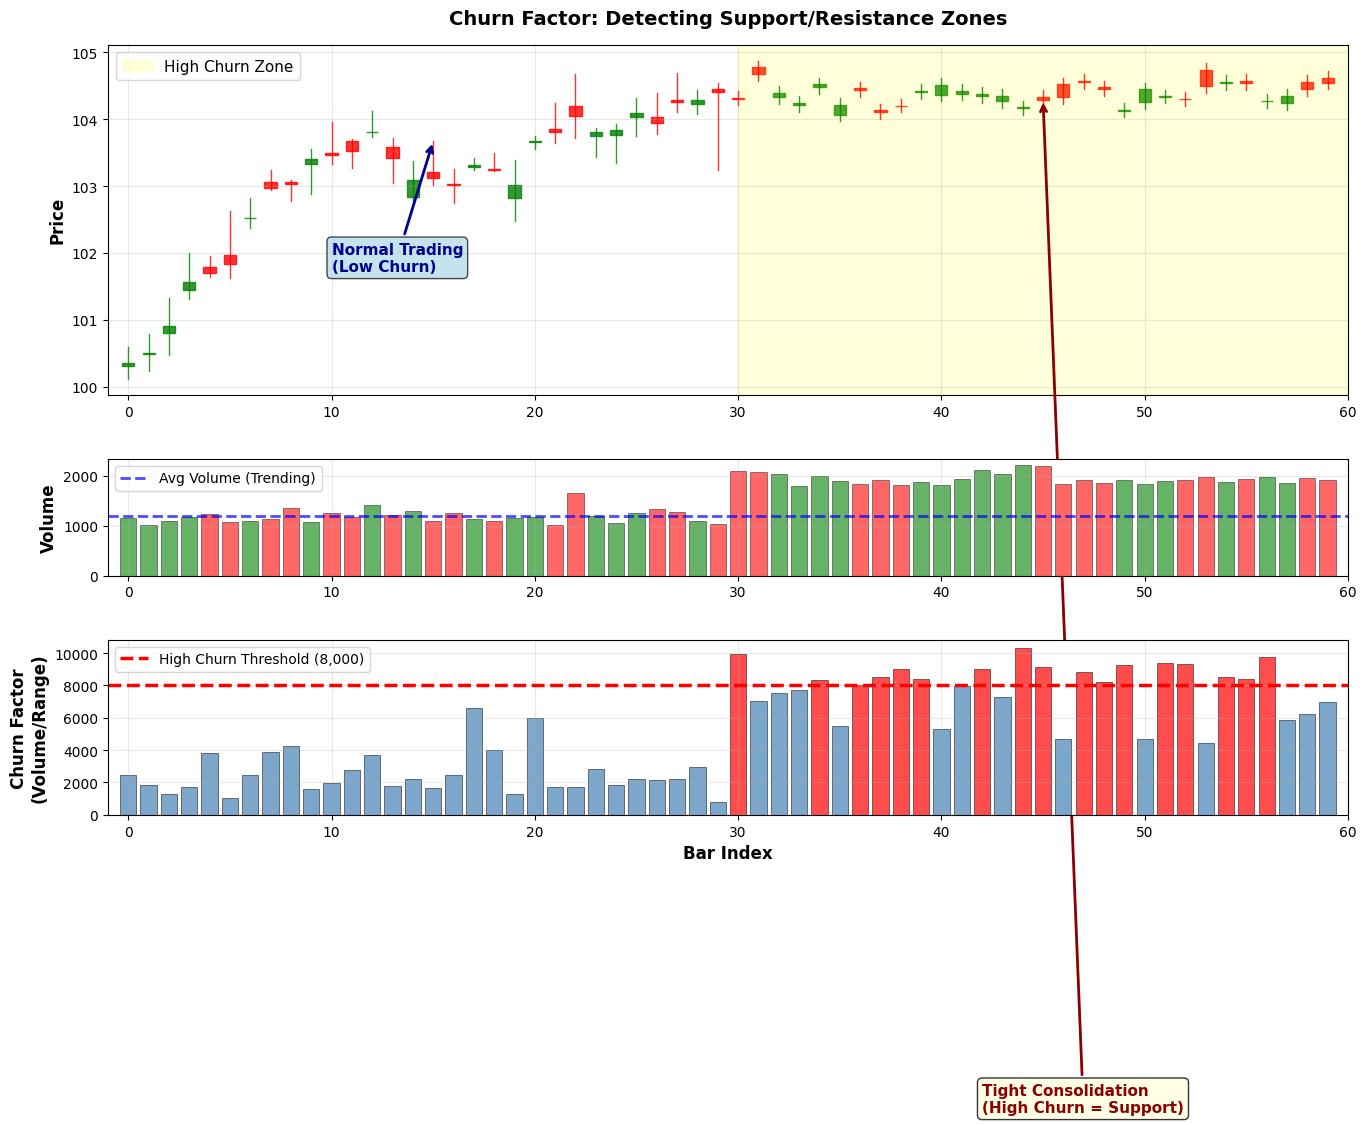

CHURN FACTOR ANALYSIS

Phase 1: Normal Trading (Bars 0-30)
  Average churn:     2,575
  Average range:     $0.57
  Average volume:    1,187

Phase 2: Consolidation (Bars 30-60)
  Average churn:     7,791
  Average range:     $0.26
  Average volume:    1,946

Churn Increase:      3.0x
Range Decrease:      2.2x tighter

⚠️  High churn indicates strong support at $104.38
💡 This level is being actively defended with high volume!


In [2]:
# Create realistic OHLCV data with consolidation phase
n = 60
dates = pd.date_range("2024-01-01 09:30", periods=n, freq="5min")

# Phase 1: Trending (normal churn)
trend_returns = np.random.randn(30) * 0.003 + 0.002
trend_prices = 100 * np.exp(np.cumsum(trend_returns))

# Phase 2: Tight consolidation (high churn)
consol_base = trend_prices[-1]
consol_prices = consol_base + np.random.randn(30) * 0.15  # Very tight range

closes = np.concatenate([trend_prices, consol_prices])

# Create OHLC data
# During trending: normal ranges
# During consolidation: very tight ranges (high churn)
opens = closes + np.random.randn(n) * 0.1
highs = np.maximum(opens, closes) + np.abs(np.random.randn(n)) * 0.3
lows = np.minimum(opens, closes) - np.abs(np.random.randn(n)) * 0.3

# Make consolidation phase very tight
highs[30:] = np.maximum(opens[30:], closes[30:]) + 0.1
lows[30:] = np.minimum(opens[30:], closes[30:]) - 0.1

# Volume: Higher during consolidation (accumulation)
volumes = 1000 + np.abs(np.random.randn(n)) * 200
volumes[30:] += 800  # Much higher volume during consolidation

# Create DataFrame with DatetimeIndex (required for mplfinance)
df1 = pd.DataFrame(
    {"Open": opens, "High": highs, "Low": lows, "Close": closes, "Volume": volumes},
    index=dates,
)

# Calculate churn factor
result1 = churn_factor(
    df1.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        }
    )
)

# Add churn to dataframe for plotting
df1["Churn"] = result1["churn_factor"].values

# Create custom plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 1, height_ratios=[3, 1, 1.5], hspace=0.3)

# Candlestick chart
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Plot candlesticks manually for more control
for i in range(len(df1)):
    color = "green" if df1["Close"].iloc[i] >= df1["Open"].iloc[i] else "red"
    # High-low line
    ax1.plot(
        [i, i],
        [df1["Low"].iloc[i], df1["High"].iloc[i]],
        color=color,
        linewidth=1,
        alpha=0.8,
    )
    # Body
    height = abs(df1["Close"].iloc[i] - df1["Open"].iloc[i])
    bottom = min(df1["Open"].iloc[i], df1["Close"].iloc[i])
    ax1.add_patch(
        plt.Rectangle(
            (i - 0.3, bottom), 0.6, height, facecolor=color, edgecolor=color, alpha=0.8
        )
    )

# Highlight consolidation zone
ax1.axvspan(30, 60, alpha=0.15, color="yellow", label="High Churn Zone")
ax1.set_ylabel("Price", fontsize=12, fontweight="bold")
ax1.set_title(
    "Churn Factor: Detecting Support/Resistance Zones",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax1.legend(loc="upper left", fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(df1))

# Volume bars
colors_vol = [
    "green" if df1["Close"].iloc[i] >= df1["Open"].iloc[i] else "red"
    for i in range(len(df1))
]
ax2.bar(
    range(len(df1)),
    df1["Volume"],
    color=colors_vol,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
)
ax2.set_ylabel("Volume", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.axhline(
    df1["Volume"].iloc[:30].mean(),
    color="blue",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Avg Volume (Trending)",
)
ax2.legend(loc="upper left", fontsize=10)

# Churn Factor
churn_threshold = 8000
colors_churn = ["red" if c > churn_threshold else "steelblue" for c in df1["Churn"]]
ax3.bar(
    range(len(df1)),
    df1["Churn"],
    color=colors_churn,
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
)
ax3.axhline(
    churn_threshold,
    color="red",
    linestyle="--",
    linewidth=2.5,
    label=f"High Churn Threshold ({churn_threshold:,})",
)
ax3.set_xlabel("Bar Index", fontsize=12, fontweight="bold")
ax3.set_ylabel("Churn Factor\n(Volume/Range)", fontsize=12, fontweight="bold")
ax3.legend(loc="upper left", fontsize=10)
ax3.grid(True, alpha=0.3)

# Add annotations
ax1.annotate(
    "Normal Trading\n(Low Churn)",
    xy=(15, df1["High"].iloc[15]),
    xytext=(10, df1["High"].max() * 0.97),
    fontsize=11,
    fontweight="bold",
    color="darkblue",
    bbox={"boxstyle": "round", "facecolor": "lightblue", "alpha": 0.7},
    arrowprops={"arrowstyle": "->", "color": "darkblue", "lw": 2},
)

ax1.annotate(
    "Tight Consolidation\n(High Churn = Support)",
    xy=(45, df1["Close"].iloc[45]),
    xytext=(42, df1["High"].max() * 0.85),
    fontsize=11,
    fontweight="bold",
    color="darkred",
    bbox={"boxstyle": "round", "facecolor": "lightyellow", "alpha": 0.8},
    arrowprops={"arrowstyle": "->", "color": "darkred", "lw": 2},
)

plt.tight_layout()
plt.show()

# Statistics
print("=" * 60)
print("CHURN FACTOR ANALYSIS")
print("=" * 60)
print("\nPhase 1: Normal Trading (Bars 0-30)")
print(f"  Average churn:     {df1['Churn'].iloc[:30].mean():,.0f}")
print(f"  Average range:     ${(df1['High'] - df1['Low']).iloc[:30].mean():.2f}")
print(f"  Average volume:    {df1['Volume'].iloc[:30].mean():,.0f}")

print("\nPhase 2: Consolidation (Bars 30-60)")
print(f"  Average churn:     {df1['Churn'].iloc[30:].mean():,.0f}")
print(f"  Average range:     ${(df1['High'] - df1['Low']).iloc[30:].mean():.2f}")
print(f"  Average volume:    {df1['Volume'].iloc[30:].mean():,.0f}")

print(
    f"\nChurn Increase:      {(df1['Churn'].iloc[30:].mean() / df1['Churn'].iloc[:30].mean()):.1f}x"
)
print(
    f"Range Decrease:      {((df1['High'] - df1['Low']).iloc[:30].mean() / (df1['High'] - df1['Low']).iloc[30:].mean()):.1f}x tighter"
)
print(
    f"\n⚠️  High churn indicates strong support at ${df1['Close'].iloc[30:].mean():.2f}"
)
print("💡 This level is being actively defended with high volume!")

## Scenario 2: Breakout from High Churn Zone
Watch what happens when price finally breaks out of a high churn consolidation

/tmp/user/ipykernel_1465937/3792976475.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


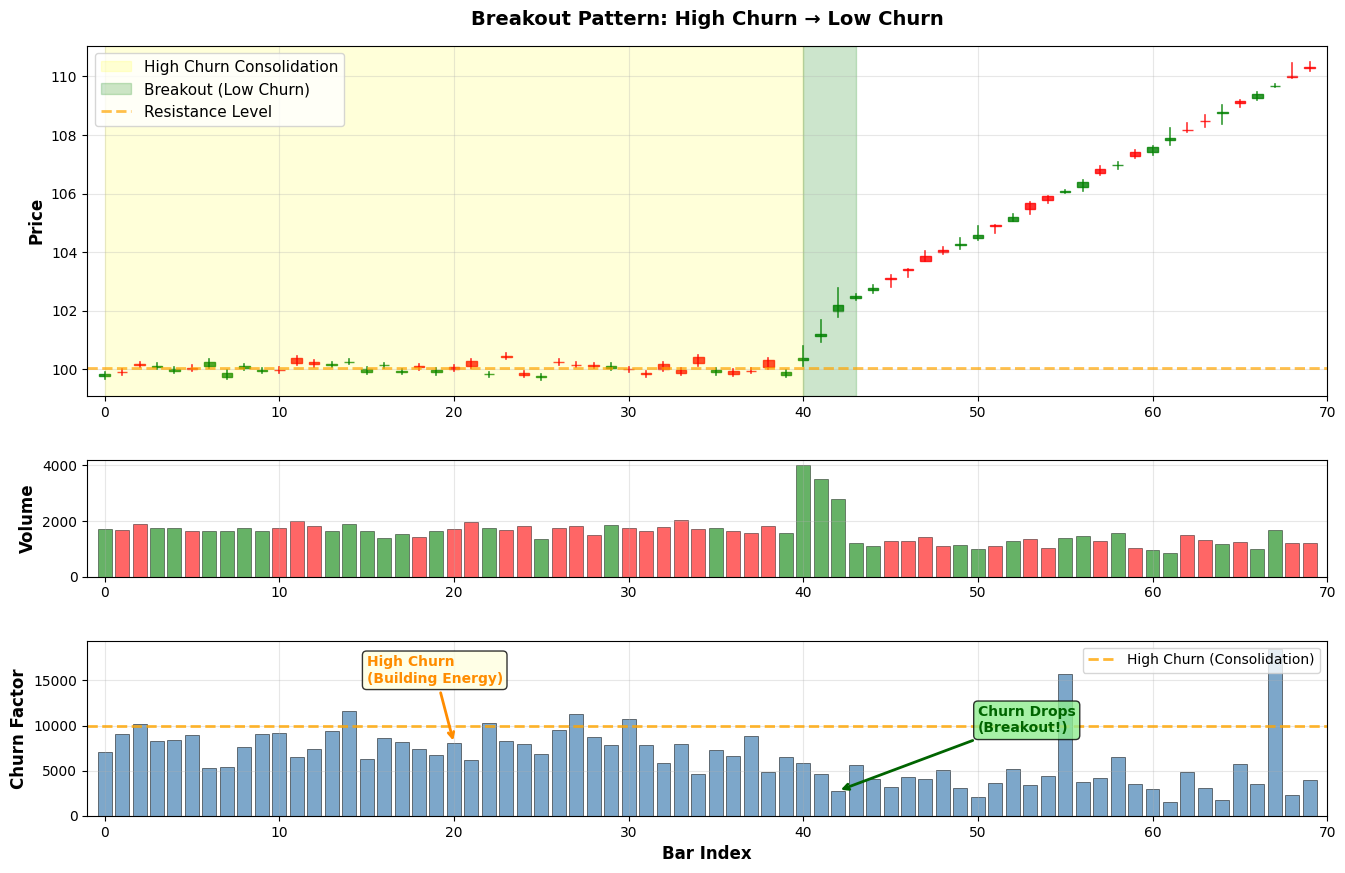

BREAKOUT ANALYSIS

Consolidation Phase (Bars 0-40):
  Avg churn:    7,922  (HIGH - accumulation)
  Price range:  $99.76 - $100.42

Breakout (Bars 40-43):
  Avg churn:    4,407  (LOW - expansion)
  Price move:   +$2.30
  Volume spike: 4,000 (explosive)

💡 Trading Signal: High churn → Low churn = Breakout confirmation!
⚠️  The sudden drop in churn validates the breakout


In [3]:
# Create data: consolidation -> breakout
n2 = 70
dates2 = pd.date_range("2024-01-01 09:30", periods=n2, freq="5min")

# Build price action
consol_prices = 100 + np.random.randn(40) * 0.2  # Tight consolidation
breakout_prices = consol_prices[-1] + np.cumsum(
    np.array([0.5, 0.8, 1.0] + [0.3] * 27)
)  # Sharp breakout
prices = np.concatenate([consol_prices, breakout_prices])

# Create OHLC
opens2 = prices + np.random.randn(n2) * 0.1
closes2 = prices
highs2 = np.maximum(opens2, closes2) + np.abs(np.random.randn(n2)) * 0.15
lows2 = np.minimum(opens2, closes2) - np.abs(np.random.randn(n2)) * 0.15

# Tight ranges during consolidation
highs2[:40] = np.maximum(opens2[:40], closes2[:40]) + 0.08
lows2[:40] = np.minimum(opens2[:40], closes2[:40]) - 0.08

# Wider ranges during breakout
highs2[40:43] = np.maximum(opens2[40:43], closes2[40:43]) + [0.4, 0.5, 0.6]
lows2[40:43] = np.minimum(opens2[40:43], closes2[40:43]) - 0.2

# Volume: High during consolidation, explosive during breakout, then normalizes
volumes2 = np.ones(n2) * 1200
volumes2[:40] += np.random.randn(40) * 150 + 500  # High during consolidation
volumes2[40:43] = [4000, 3500, 2800]  # Explosive breakout volume
volumes2[43:] += np.random.randn(27) * 200  # Normal after breakout

df2 = pd.DataFrame(
    {
        "Open": opens2,
        "High": highs2,
        "Low": lows2,
        "Close": closes2,
        "Volume": volumes2,
    },
    index=dates2,
)

result2 = churn_factor(
    df2.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        }
    )
)
df2["Churn"] = result2["churn_factor"].values

# Create plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 1, height_ratios=[3, 1, 1.5], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Candlesticks
for i in range(len(df2)):
    color = "green" if df2["Close"].iloc[i] >= df2["Open"].iloc[i] else "red"
    ax1.plot(
        [i, i],
        [df2["Low"].iloc[i], df2["High"].iloc[i]],
        color=color,
        linewidth=1.2,
        alpha=0.8,
    )
    height = abs(df2["Close"].iloc[i] - df2["Open"].iloc[i])
    bottom = min(df2["Open"].iloc[i], df2["Close"].iloc[i])
    ax1.add_patch(
        plt.Rectangle(
            (i - 0.3, bottom), 0.6, height, facecolor=color, edgecolor=color, alpha=0.8
        )
    )

# Highlight zones
ax1.axvspan(0, 40, alpha=0.15, color="yellow", label="High Churn Consolidation")
ax1.axvspan(40, 43, alpha=0.2, color="green", label="Breakout (Low Churn)")
ax1.axhline(
    df2["Close"].iloc[:40].mean(),
    color="orange",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Resistance Level",
)
ax1.set_ylabel("Price", fontsize=12, fontweight="bold")
ax1.set_title(
    "Breakout Pattern: High Churn → Low Churn", fontsize=14, fontweight="bold", pad=15
)
ax1.legend(loc="upper left", fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(df2))

# Volume
colors_vol2 = [
    "green" if df2["Close"].iloc[i] >= df2["Open"].iloc[i] else "red"
    for i in range(len(df2))
]
ax2.bar(
    range(len(df2)),
    df2["Volume"],
    color=colors_vol2,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
)
ax2.set_ylabel("Volume", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3)

# Churn Factor
ax3.bar(
    range(len(df2)),
    df2["Churn"],
    color="steelblue",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
)
ax3.axhline(
    10000,
    color="orange",
    linestyle="--",
    linewidth=2,
    label="High Churn (Consolidation)",
    alpha=0.8,
)
ax3.set_xlabel("Bar Index", fontsize=12, fontweight="bold")
ax3.set_ylabel("Churn Factor", fontsize=12, fontweight="bold")
ax3.legend(loc="upper right", fontsize=10)
ax3.grid(True, alpha=0.3)

# Annotations
ax3.annotate(
    "High Churn\n(Building Energy)",
    xy=(20, df2["Churn"].iloc[20]),
    xytext=(15, df2["Churn"].max() * 0.8),
    fontsize=10,
    fontweight="bold",
    color="darkorange",
    bbox={"boxstyle": "round", "facecolor": "lightyellow", "alpha": 0.8},
    arrowprops={"arrowstyle": "->", "color": "darkorange", "lw": 2},
)

ax3.annotate(
    "Churn Drops\n(Breakout!)",
    xy=(42, df2["Churn"].iloc[42]),
    xytext=(50, df2["Churn"].max() * 0.5),
    fontsize=10,
    fontweight="bold",
    color="darkgreen",
    bbox={"boxstyle": "round", "facecolor": "lightgreen", "alpha": 0.8},
    arrowprops={"arrowstyle": "->", "color": "darkgreen", "lw": 2},
)

plt.tight_layout()
plt.show()

print("=" * 60)
print("BREAKOUT ANALYSIS")
print("=" * 60)
print("\nConsolidation Phase (Bars 0-40):")
print(f"  Avg churn:    {df2['Churn'].iloc[:40].mean():,.0f}  (HIGH - accumulation)")
print(
    f"  Price range:  ${df2['Close'].iloc[:40].min():.2f} - ${df2['Close'].iloc[:40].max():.2f}"
)

print("\nBreakout (Bars 40-43):")
print(f"  Avg churn:    {df2['Churn'].iloc[40:43].mean():,.0f}  (LOW - expansion)")
print(f"  Price move:   +${df2['Close'].iloc[42] - df2['Close'].iloc[39]:.2f}")
print(f"  Volume spike: {df2['Volume'].iloc[40]:,.0f} (explosive)")

print("\n💡 Trading Signal: High churn → Low churn = Breakout confirmation!")
print("⚠️  The sudden drop in churn validates the breakout")

## Scenario 3: Fill Strategy Comparison
How to handle zero-range bars (doji bars where high = low)

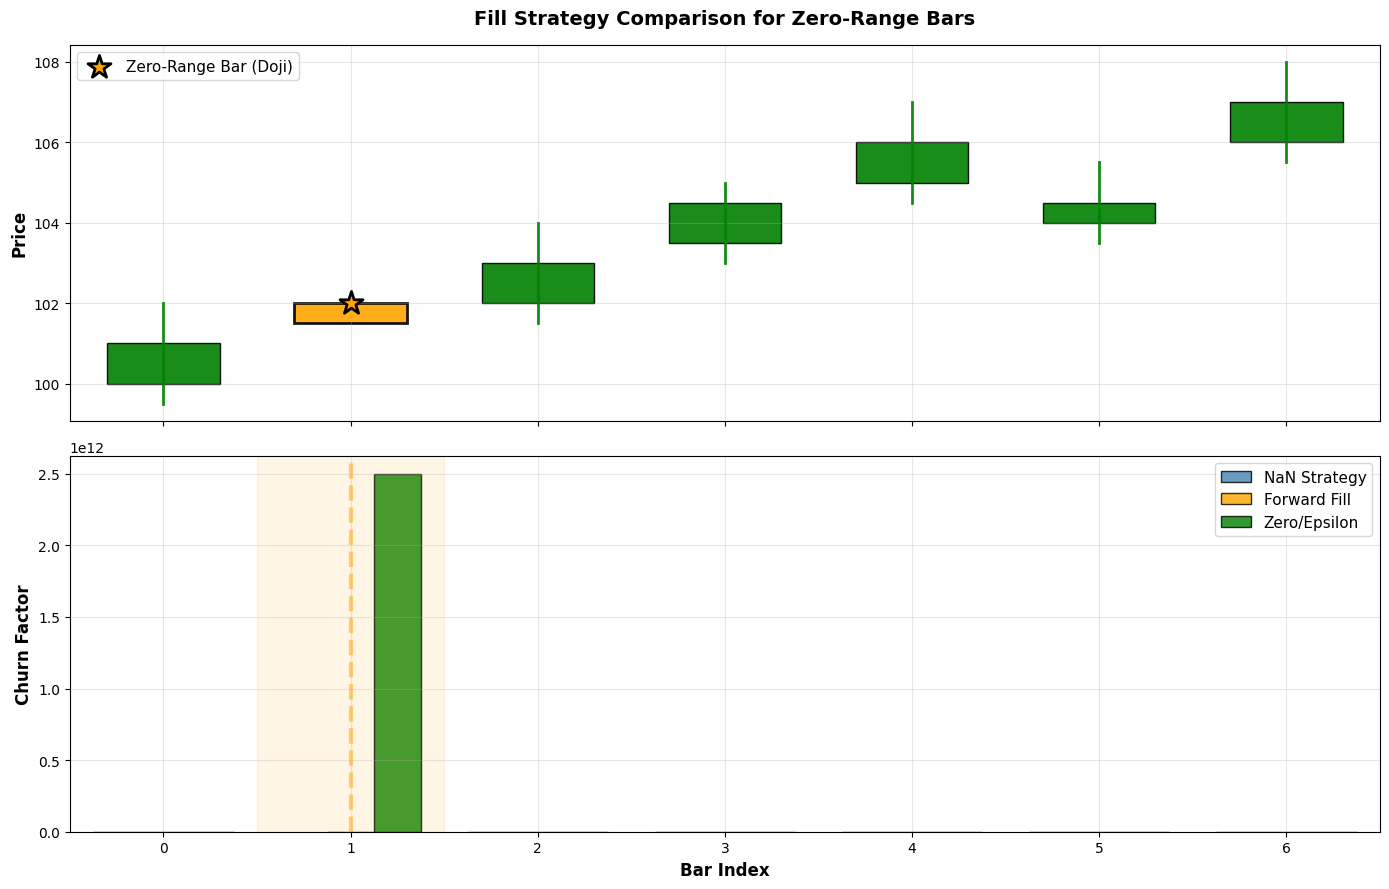

FILL STRATEGY COMPARISON (Bar 1 has zero range)

Bar 1 Details:
  High = Low:     $102.00 (zero range)
  Volume:         2,500
  Type:           Doji (indecision)

Churn Factor at Bar 1:
  NaN Strategy:      nan (undefined)
  Forward Fill:      400 (uses Bar 0 value)
  Zero/Epsilon:      2,500,000,000,000 (vol/epsilon)

💡 Recommendation:
   - Use 'zero' strategy for most cases (prevents NaN gaps)
   - Use 'nan' if you want to explicitly ignore doji bars
   - Use 'forward_fill' to smooth over occasional dojis


In [4]:
# Create data with a zero-range bar (doji)
dates3 = pd.date_range("2024-01-01 10:00", periods=7, freq="5min")

df3 = pd.DataFrame(
    {
        "Open": [100.0, 101.5, 102.0, 103.5, 105.0, 104.0, 106.0],
        "High": [
            102.0,
            102.0,
            104.0,
            105.0,
            107.0,
            105.5,
            108.0,
        ],  # Bar 1: high = low (zero range)
        "Low": [99.5, 102.0, 101.5, 103.0, 104.5, 103.5, 105.5],  # Bar 1: high = low
        "Close": [101.0, 102.0, 103.0, 104.5, 106.0, 104.5, 107.0],
        "Volume": [1000, 2500, 1800, 1500, 2000, 1600, 1900],
    },
    index=dates3,
)

# Calculate with different strategies
result_nan = churn_factor(
    df3.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        }
    ),
    fill_strategy="nan",
)

result_ffill = churn_factor(
    df3.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        }
    ),
    fill_strategy="forward_fill",
)

result_zero = churn_factor(
    df3.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        }
    ),
    fill_strategy="zero",
)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

# Price bars with zero-range highlighted
for i in range(len(df3)):
    color = "green" if df3["Close"].iloc[i] >= df3["Open"].iloc[i] else "red"
    if i == 1:  # Zero-range bar
        color = "orange"
    ax1.plot(
        [i, i],
        [df3["Low"].iloc[i], df3["High"].iloc[i]],
        color=color,
        linewidth=2,
        alpha=0.9,
    )
    height = abs(df3["Close"].iloc[i] - df3["Open"].iloc[i])
    if height < 0.01:  # Doji
        height = 0.2
    bottom = min(df3["Open"].iloc[i], df3["Close"].iloc[i])
    ax1.add_patch(
        plt.Rectangle(
            (i - 0.3, bottom),
            0.6,
            height,
            facecolor=color,
            edgecolor="black",
            linewidth=2 if i == 1 else 1,
            alpha=0.9,
        )
    )

ax1.scatter(
    [1],
    [df3["Close"].iloc[1]],
    s=300,
    marker="*",
    color="orange",
    edgecolor="black",
    linewidth=2,
    zorder=5,
    label="Zero-Range Bar (Doji)",
)
ax1.set_ylabel("Price", fontsize=12, fontweight="bold")
ax1.set_title(
    "Fill Strategy Comparison for Zero-Range Bars",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax1.legend(loc="upper left", fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.5, len(df3) - 0.5)

# Churn comparison
x = np.arange(len(df3))
width = 0.25

bars1 = ax2.bar(
    x - width,
    result_nan["churn_factor"],
    width,
    label="NaN Strategy",
    alpha=0.8,
    color="steelblue",
    edgecolor="black",
    linewidth=1,
)
bars2 = ax2.bar(
    x,
    result_ffill["churn_factor"],
    width,
    label="Forward Fill",
    alpha=0.8,
    color="orange",
    edgecolor="black",
    linewidth=1,
)
bars3 = ax2.bar(
    x + width,
    result_zero["churn_factor"],
    width,
    label="Zero/Epsilon",
    alpha=0.8,
    color="green",
    edgecolor="black",
    linewidth=1,
)

# Highlight the zero-range bar
ax2.axvline(1, color="orange", linestyle="--", linewidth=3, alpha=0.5)
ax2.axvspan(0.5, 1.5, alpha=0.1, color="orange")

ax2.set_xlabel("Bar Index", fontsize=12, fontweight="bold")
ax2.set_ylabel("Churn Factor", fontsize=12, fontweight="bold")
ax2.legend(loc="upper right", fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(x)

plt.tight_layout()
plt.show()

print("=" * 70)
print("FILL STRATEGY COMPARISON (Bar 1 has zero range)")
print("=" * 70)
print("\nBar 1 Details:")
print(f"  High = Low:     ${df3['High'].iloc[1]:.2f} (zero range)")
print(f"  Volume:         {df3['Volume'].iloc[1]:,.0f}")
print("  Type:           Doji (indecision)")

print("\nChurn Factor at Bar 1:")
print(f"  NaN Strategy:      {result_nan['churn_factor'].iloc[1]} (undefined)")
print(
    f"  Forward Fill:      {result_ffill['churn_factor'].iloc[1]:,.0f} (uses Bar 0 value)"
)
print(f"  Zero/Epsilon:      {result_zero['churn_factor'].iloc[1]:,.0f} (vol/epsilon)")

print("\n💡 Recommendation:")
print("   - Use 'zero' strategy for most cases (prevents NaN gaps)")
print("   - Use 'nan' if you want to explicitly ignore doji bars")
print("   - Use 'forward_fill' to smooth over occasional dojis")

## Key Takeaways

### High Churn Indicates:
1. **Strong Support/Resistance**: Price level is being actively defended
2. **Accumulation/Distribution**: Institutions building/unloading positions
3. **Breakout Preparation**: Energy building for potential move
4. **Tight Consolidation**: Price compressed in narrow range with volume

### Low Churn Indicates:
1. **Trending Market**: Large price swings with normal volume
2. **Low Conviction**: Not much interest at current prices
3. **Breakout in Progress**: After high churn, drop signals expansion

### Trading Applications:

**Pattern Recognition:**
- High Churn Zone → Watch for breakout
- Churn Spike → Support/resistance forming
- Churn Drop after High Churn → Breakout confirmation

**Position Management:**
- **High Churn**: Reduce size (tight stops likely to be hit)
- **Churn Breakdown**: Increase size (trend starting)
- **Persistent High Churn**: Wait for resolution (don't fight the range)

### Fill Strategies for Zero-Range Bars:

| Strategy | Behavior | Best For |
|----------|----------|----------|
| `nan` | Keeps NaN | Analysis where you want to explicitly identify dojis |
| `forward_fill` | Uses previous value | Smoothing over occasional dojis |
| `zero` | Uses epsilon (very large value) | Most trading applications (prevents gaps) |

### Typical Churn Thresholds:
- **< 2,000**: Low churn (trending)
- **2,000 - 5,000**: Normal
- **5,000 - 10,000**: Elevated (watch closely)
- **> 10,000**: Very high (strong support/resistance)

*Note: Thresholds vary by asset and timeframe. Calibrate based on historical data.*

### Best Practices:
1. **Compare to historical churn** for the same asset
2. **Combine with price action** (don't trade churn alone)
3. **Watch for churn divergences** (increasing churn + sideways price = coiling)
4. **Use on multiple timeframes** (daily + intraday confirmation)
5. **Adjust thresholds** per asset volatility

### Warning Signs:
⚠️ **Extremely high churn** (>20,000) may indicate:
- Manipulation (spoofing)
- News pending
- Major support/resistance test

⚠️ **Sudden churn spikes** often precede:
- Breakouts (up or down)
- Reversals
- Volatility expansion

## Feature Showcase: Safety & Configuration

In [ ]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator.churn_factor import churn_factor

# 1. Configuration with .Config()
print(f"--- Custom churn_factor Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_churn_factor = churn_factor.Config(epsilon=1e-5).make()
print(f"Created: {custom_churn_factor}")

# 2. Validation Safety
print(f"
--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (missing columns)
    invalid_data = pd.DataFrame({'close': [100]}) # Missing high/low/volume
    print("Attempting calculation with invalid inputs...")
    churn_factor(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected:
  {e}")
